## Import libraries

In [98]:
# data manipulation
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

# linear algebra
import numpy as np

# machine learning
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, StratifiedKFold, train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix

# visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from spacy.lang.en.stop_words import STOP_WORDS
%matplotlib inline

## Import dataset

In [99]:
df = pd.read_csv('train_lemma.csv')
df.head()

,tweet,polarity
0,aww that be bummer you shoulda get david carr ...,0
1,be upset that he can not update his facebook b...,0
2,dive many time for the ball manage to save 50 ...,0
3,my whole body feel itchy and like its on fire,0
4,no it be not behave at all be mad why be here ...,0


## Sentiment visualization using WordCloud

In [3]:
df_pos = df[df['polarity']==1].copy()
df_neg = df[df['polarity']==0].copy()

In [4]:
pos_words = ''
neg_words = ''

for tweet in df_pos['tweet']:
    tweet = str(tweet)
    tokens = tweet.lower().split()
    pos_words += ' '.join(tokens) + ' '

for tweet in df_neg['tweet']:
    tweet = str(tweet)
    tokens = tweet.lower().split()
    neg_words += ' '.join(tokens) + ' '

In [5]:
pos_wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=STOP_WORDS, min_font_size=10).generate(pos_words)
neg_wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=STOP_WORDS, min_font_size=10).generate(neg_words)

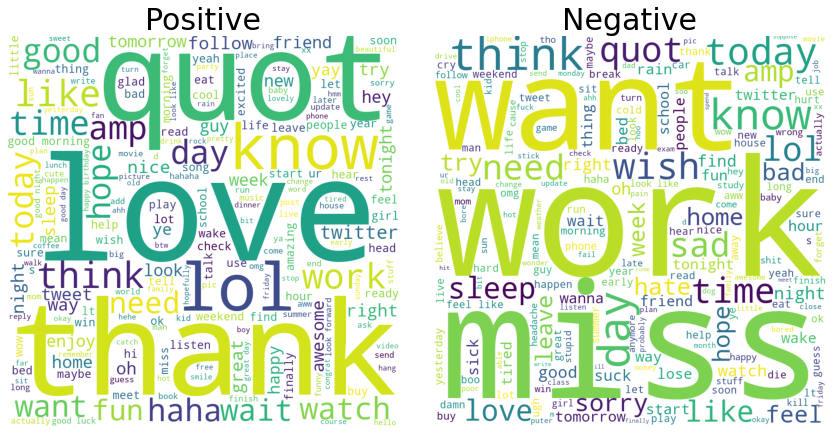

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))

axes[0].imshow(pos_wordcloud)
axes[0].set_title('Positive', fontsize=30)
axes[0].axis('off')

axes[1].imshow(neg_wordcloud)
axes[1].set_title('Negative', fontsize=30)
axes[1].axis('off')

fig.tight_layout();

## Data preparation

In [100]:
X = df['tweet']
y = df['polarity']

# return score - for svc
def evaluate_model(model, X, y, metrics='accuracy'):
    tfidf = TfidfVectorizer(ngram_range=(1, 3), max_df=0.5, min_df=2)
    pipeline = Pipeline(steps=[('tfidf',tfidf),('model',model)])
    
    cv = KFold(10,shuffle=True,random_state=143)
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring=metrics)
    return scores

# return probability
def evaluate_proba(model, X, y):
    tfidf = TfidfVectorizer(ngram_range=(1, 3), max_df=0.5, min_df=2)
    pipeline = Pipeline(steps=[('tfidf',tfidf),('model',model)])
    
    cv = KFold(10,shuffle=True,random_state=143)
    proba = cross_val_predict(pipeline, X, y, cv=cv, method='predict_proba')
    return proba

## Model validation
### First stage - Naive Bayes

In [22]:
model_1 = ComplementNB()
first_proba = evaluate_proba(model_1, X, y)

In [23]:
a = np.where(np.logical_and(first_proba[:,1] > first_proba[:,0], first_proba[:,1] < 0.95))[0].tolist()
b = np.where(np.logical_and(first_proba[:,0] > first_proba[:,1], first_proba[:,0] < 0.95))[0].tolist()

a.extend(b)
a = np.array(a)
a = a.tolist()

first_success = np.delete(first_proba, a, 0)
y_success = np.delete(np.array(y),a)
first_success = np.where(first_success[:,1] > 0.5, 1, 0)

We set 0.95 as our threshold. Any data points with probability less than this threshold will be forwarded to the second stage.

### Second stage - Support Vector Machine

In [24]:
model_2 = LinearSVC(random_state=143,
                    penalty='l1',
                    dual=False,
                    C=0.45)

second_score = evaluate_model(model_2, X[a], y[a])

In [25]:
h, i = np.diag(confusion_matrix(y_success,first_success))
second_score_mean = np.mean(second_score) * len(X[a])

overall_score = (h + i + second_score_mean) / len(df)
print(f'Accuracy score: {overall_score*100:.3f} %')

Accuracy score: 78.964 %


## Model training

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=143)

In [117]:
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_df=0.5, min_df=2)

X_train_vect = tfidf.fit_transform(X_train)
X_test_vect = tfidf.transform(X_test)

## First stage

In [118]:
model_1.fit(X_train_vect,y_train)
first_proba = model_1.predict_proba(X_test_vect)

In [119]:
a = np.where(np.logical_and(first_proba[:,1] > first_proba[:,0], first_proba[:,1] < 0.95))[0].tolist()
b = np.where(np.logical_and(first_proba[:,0] > first_proba[:,1], first_proba[:,0] < 0.95))[0].tolist()

In [120]:
a.extend(b)
a = np.array(a)
a = a.tolist()

first_success = np.delete(first_proba, a, 0)
y_success = np.delete(np.array(y_test),a)
first_success = np.where(first_success[:,1] > 0.5, 1, 0)

## Second stage

In [121]:
model_2 = LinearSVC(random_state=143,
                    penalty='l1',
                    dual=False,
                    C=0.45)

In [122]:
model_2.fit(X_train_vect[a],y_train.values[a])
predictions = model_2.predict(X_test_vect[a])

## Model evaluation

In [123]:
h, i = np.diag(confusion_matrix(y_success,first_success))
second_score = accuracy_score(y_test.values[a],predictions)
second_score_mean = np.mean(second_score) * X_test_vect[a].shape[0]

overall_score = (h + i + second_score_mean) / len(X_test)

In [124]:
print(f'Accuracy score: {overall_score*100:.3f} %')

Accuracy score: 81.531 %
